# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Installing Pytorch

In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


In [0]:
from torchvision import datasets, transforms, models

## Import PIL and install PIL

In [3]:
import PIL
import os
kill=False
print("version : ",PIL.PILLOW_VERSION)

if PIL.PILLOW_VERSION =="4.0.0":
  !pip uninstall -y Pillow
  !pip install Pillow==5.3.0
  # import the new one
  import PIL
  print("version : ",PIL.PILLOW_VERSION)
  # this should print 5.3.0. If it doesn't, then restart your runtime:
  # Menu > Runtime > Restart Runtime
  if PIL.PILLOW_VERSION =="4.0.0":
    os.kill(os.getpid(), 9)

version :  5.3.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

## Get Flower Data
### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
!wget -nc https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -n flower_data.zip >null
!wget -nc https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

--2019-01-02 18:19:42--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  16.4MB/s    in 42s     

2019-01-02 18:20:25 (7.02 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

--2019-01-02 18:20:33--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[

# Imports

In [0]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

## Data directories

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

## Creating data loaders

In [7]:

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 25
# Validation set size
valid_size= 0.1

# TODO: Define your transforms for the training and validation sets

train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.ColorJitter(brightness=0.3,saturation=0.2),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(train_dir, transform=test_transforms)
test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)


#Validation portion 
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# TODO: Using the image datasets and the trainforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)

print("Training size : ",len(train_loader))
print("Validation size : ",len(valid_loader))
print("Testing size : ",len(test_loader))
print(train_data.class_to_idx)


Training size :  236
Validation size :  27
Testing size :  33
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93

## Create Pretrained Model

In [8]:
model = models.densenet161(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 71914655.26it/s]


In [9]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Building the classifier part

In [0]:
# TODO: Build your network
#Freezing the parameters
for param in model.parameters():
    param.requires_grad = False

class Network(nn.Module):
  def __init__(self,n_hidden1=1024,n_hidden2=512):
    super().__init__()
    
    self.fc1=nn.Linear(2208,n_hidden1)
    self.relu1=nn.ReLU()
    self.fc2=nn.Linear(n_hidden1,n_hidden2)
    self.relu2=nn.ReLU()
    #self.fc3=nn.Linear(n_hidden2,n_hidden3)
    #self.relu3=nn.ReLU()
    self.output=nn.Linear(n_hidden2,102)
    self.dropout=nn.Dropout(p=0.25)
    
  def forward(self,x):
    
    x=self.relu1(self.fc1(x))
    x=self.dropout(x)
    x=self.relu2(self.fc2(x))
    x=self.dropout(x)
    #x=self.relu3(self.fc3(x))
    #x=self.dropout(x)
    x=self.output(x)
    #x=F.log_softmax(x,dim=1)
    
    return x
  
model.classifier=Network()
model=model.cuda()

### Defining save and load model

In [11]:
# TODO: Train your network
def save_model(model,minimum_loss,filename):
  st=model.state_dict()
  torch.save({"minloss":minimum_loss,"state":st},filename)
  
def load_model(filename):
  return torch.load(filename)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
'''
model.load_state_dict(load_model("/content/min_densenet161_0.6997023820877075.pt"))
model=model.cuda()
optimizer=optim.Adam(model.classifier.parameters(),lr=0.005)
model

'''


'\nmodel.load_state_dict(load_model("/content/min_densenet161_0.6997023820877075.pt"))\nmodel=model.cuda()\noptimizer=optim.Adam(model.classifier.parameters(),lr=0.005)\nmodel\n\n'

# Import drive

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Training the network
## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
import time
def trainCEL(model,n_epochs,train_loader,valid_loader,learning_rate=0.01,opt="SGD",cont=False,modelPath=None,freeze=True,N_EPOCHS_TO_UNFREEZE=30):
  minimum_loss=np.inf
  if(cont):
    chpt=load_model(modelPath)
    model.load_state_dict(chpt["state"])
    minimum_loss=chpt["minloss"]
  
  #Freeze logic
  parameters_to_train = model.classifier.parameters()
  if freeze:
    for param in model.parameters():
      param.requires_grad = False
    for param in model.classifier.parameters():
      param.requires_grad = True
  else:
    for param in model.parameters():
      param.requires_grad = True
    parameters_to_train=model.parameters()
      
      
      
  criterion = nn.CrossEntropyLoss()
  if opt=="Adam":
    optimizer=optim.Adam(parameters_to_train,lr=learning_rate)
  elif opt=="SGD":
    optimizer=optim.SGD(parameters_to_train,lr=learning_rate,momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  model.train()
  plot_training_loss=[]
  plot_validation_loss=[]
  plot_accuracy=[]
  plot_lr=[]
  startTime=time.time()
  for e in range(n_epochs):
    if not freeze:
      if((e+1)==N_EPOCHS_TO_UNFREEZE):
        for param in model.parameters():
          param.requires_grad = False
        for param in model.classifier.parameters():
          param.requires_grad = True
        if opt=="Adam":
          optimizer=optim.Adam(model.classifier.parameters(),lr=learning_rate)
        elif opt=="SGD":
          optimizer=optim.SGD(model.classifier.parameters(),lr=learning_rate,momentum=0.9)
      
      
    running_loss=0
    step=0
    startEpoch=time.time()
    for images,labels in train_loader:
      #move variables to GPU
      images,labels = images.cuda(),labels.cuda()

      optimizer.zero_grad()
      #forward
      output=model(images)
      #calculate loss
      loss=criterion(output,labels)
      #backpropagate
      loss.backward()
      #update weights
      optimizer.step()
      #accumulate loss
      running_loss+=loss.item()
      step+=1
      if(step%25 ==0):
        print(f"Epoch {e+1} , Batch {step}/{len(train_loader)} Loss:{loss} Running time Epoch: {time.time()-startEpoch:.3f} s, Running Time: {time.time()-startTime:.3f} s")

    running_loss/=len(train_loader)
    #add to the list to plot
    plot_training_loss.append(running_loss)
    
    #Validation part 
    validation_loss=0
    accuracy=0

    model.eval()
    with torch.no_grad():
        for images,labels in valid_loader:
          #move variables to GPU
          images,labels = images.cuda(),labels.cuda()

          #forward
          output=model(images)
          #calculate loss
          loss=criterion(output,labels)

          #calculate validation loss 
          validation_loss+=loss.item()
          #calculate accuracy
          ps=F.softmax(output,dim=1)
          top_p,top_c= ps.topk(1,dim=1)
          equals= labels == top_c.view(*labels.shape)
          accuracy+= equals.type(torch.FloatTensor).mean()


        validation_loss/=len(valid_loader)
        accuracy/=len(valid_loader)
        #add to the list to plot
        plot_validation_loss.append(validation_loss)
        
        scheduler.step(validation_loss)
        
        plot_lr.append(get_lr(optimizer))
        
        plot_accuracy.append(accuracy)
        
        better=False
        if validation_loss<minimum_loss:
          minimum_loss=validation_loss
          save_model(model,minimum_loss,"/content/gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_{0:.3f}.pt".format(accuracy))
          better=True

    model.train()
    print(f"======>Epoch {e+1} Finished , TLoss:{running_loss} VLoss :{validation_loss} Accuracy : {accuracy} Better : {better} Time taken: {time.time() -startEpoch}")
    ax=plt.figure()
    t=ax.add_subplot(3,1,1)
    t.plot(plot_validation_loss,label="Validation loss")
    t.plot(plot_training_loss,label="Training loss")
    plt.legend()

    v=ax.add_subplot(3,1,2)
    v.plot(plot_accuracy,label="Accuracy")
    plt.legend()
    
    l=ax.add_subplot(3,1,3)
    l.plot(plot_lr,label="Learning Rate")
    
    plt.legend()
    plt.show()

# Launch the training phase

Epoch 1 , Batch 25/236 Loss:4.584378242492676 Running time Epoch: 35.813 s, Running Time: 35.813 s
Epoch 1 , Batch 50/236 Loss:4.419195652008057 Running time Epoch: 70.008 s, Running Time: 70.008 s
Epoch 1 , Batch 75/236 Loss:3.8551974296569824 Running time Epoch: 104.327 s, Running Time: 104.327 s
Epoch 1 , Batch 100/236 Loss:3.351930618286133 Running time Epoch: 138.691 s, Running Time: 138.691 s
Epoch 1 , Batch 125/236 Loss:3.4992189407348633 Running time Epoch: 173.011 s, Running Time: 173.011 s
Epoch 1 , Batch 150/236 Loss:2.8500356674194336 Running time Epoch: 207.306 s, Running Time: 207.306 s
Epoch 1 , Batch 175/236 Loss:2.3511087894439697 Running time Epoch: 241.630 s, Running Time: 241.630 s
Epoch 1 , Batch 200/236 Loss:2.079326629638672 Running time Epoch: 275.929 s, Running Time: 275.929 s
Epoch 1 , Batch 225/236 Loss:2.329705238342285 Running time Epoch: 310.240 s, Running Time: 310.240 s
======>Epoch 1 Finished , TLoss:3.420212499671063 VLoss :1.697554831151609 Accuracy :

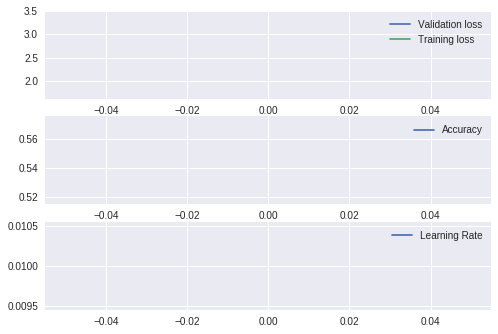

Epoch 2 , Batch 25/236 Loss:2.2995002269744873 Running time Epoch: 36.819 s, Running Time: 377.440 s
Epoch 2 , Batch 50/236 Loss:1.9668126106262207 Running time Epoch: 71.069 s, Running Time: 411.690 s
Epoch 2 , Batch 75/236 Loss:0.9231149554252625 Running time Epoch: 105.318 s, Running Time: 445.939 s
Epoch 2 , Batch 100/236 Loss:1.9344589710235596 Running time Epoch: 139.568 s, Running Time: 480.188 s
Epoch 2 , Batch 125/236 Loss:1.9714906215667725 Running time Epoch: 173.901 s, Running Time: 514.522 s
Epoch 2 , Batch 150/236 Loss:1.38242506980896 Running time Epoch: 208.216 s, Running Time: 548.837 s
Epoch 2 , Batch 175/236 Loss:1.3926910161972046 Running time Epoch: 242.536 s, Running Time: 583.157 s
Epoch 2 , Batch 200/236 Loss:1.5488015413284302 Running time Epoch: 276.831 s, Running Time: 617.452 s
Epoch 2 , Batch 225/236 Loss:1.3010882139205933 Running time Epoch: 311.130 s, Running Time: 651.751 s
======>Epoch 2 Finished , TLoss:1.5894663578878014 VLoss :1.0391757002583257 Acc

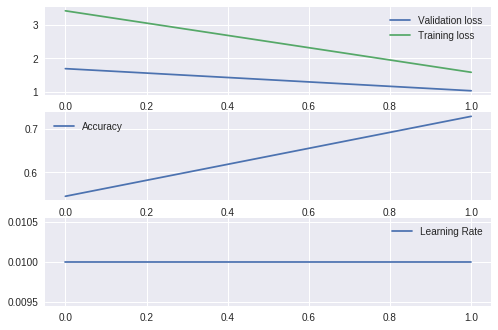

Epoch 3 , Batch 25/236 Loss:0.9859460592269897 Running time Epoch: 37.069 s, Running Time: 718.789 s
Epoch 3 , Batch 50/236 Loss:0.9031170010566711 Running time Epoch: 71.313 s, Running Time: 753.033 s
Epoch 3 , Batch 75/236 Loss:1.2511314153671265 Running time Epoch: 105.601 s, Running Time: 787.321 s
Epoch 3 , Batch 100/236 Loss:0.8977126479148865 Running time Epoch: 139.883 s, Running Time: 821.603 s
Epoch 3 , Batch 125/236 Loss:1.092970609664917 Running time Epoch: 174.189 s, Running Time: 855.909 s
Epoch 3 , Batch 150/236 Loss:1.302642822265625 Running time Epoch: 208.470 s, Running Time: 890.190 s
Epoch 3 , Batch 175/236 Loss:1.1935163736343384 Running time Epoch: 242.778 s, Running Time: 924.498 s
Epoch 3 , Batch 200/236 Loss:1.1026288270950317 Running time Epoch: 277.090 s, Running Time: 958.810 s
Epoch 3 , Batch 225/236 Loss:1.6668347120285034 Running time Epoch: 311.393 s, Running Time: 993.113 s
======>Epoch 3 Finished , TLoss:1.130065479521024 VLoss :0.5172228283352323 Accu

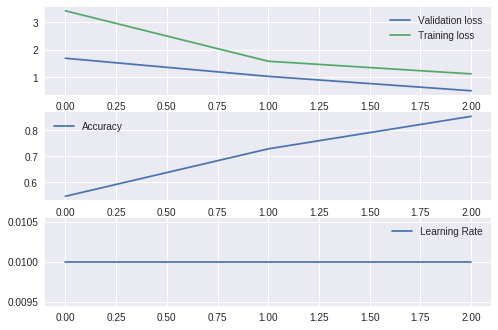

Epoch 4 , Batch 25/236 Loss:1.4091918468475342 Running time Epoch: 36.687 s, Running Time: 1060.155 s
Epoch 4 , Batch 50/236 Loss:1.1744192838668823 Running time Epoch: 70.899 s, Running Time: 1094.367 s
Epoch 4 , Batch 75/236 Loss:0.8554254174232483 Running time Epoch: 105.192 s, Running Time: 1128.660 s
Epoch 4 , Batch 100/236 Loss:0.6325773596763611 Running time Epoch: 139.482 s, Running Time: 1162.950 s
Epoch 4 , Batch 125/236 Loss:0.8734509348869324 Running time Epoch: 173.783 s, Running Time: 1197.251 s
Epoch 4 , Batch 150/236 Loss:0.8956175446510315 Running time Epoch: 208.071 s, Running Time: 1231.539 s
Epoch 4 , Batch 175/236 Loss:0.9528156518936157 Running time Epoch: 242.362 s, Running Time: 1265.830 s
Epoch 4 , Batch 200/236 Loss:0.5851055383682251 Running time Epoch: 276.643 s, Running Time: 1300.111 s
Epoch 4 , Batch 225/236 Loss:0.40566739439964294 Running time Epoch: 310.914 s, Running Time: 1334.382 s
======>Epoch 4 Finished , TLoss:0.892009758848255 VLoss :0.465160891

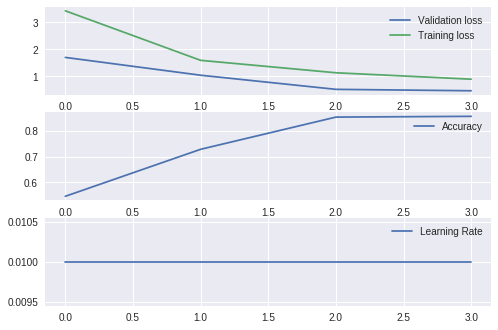

Epoch 5 , Batch 25/236 Loss:1.1493995189666748 Running time Epoch: 36.822 s, Running Time: 1401.226 s
Epoch 5 , Batch 50/236 Loss:1.0321060419082642 Running time Epoch: 71.046 s, Running Time: 1435.449 s
Epoch 5 , Batch 75/236 Loss:0.2965937852859497 Running time Epoch: 105.320 s, Running Time: 1469.724 s
Epoch 5 , Batch 100/236 Loss:0.7489408850669861 Running time Epoch: 139.613 s, Running Time: 1504.017 s
Epoch 5 , Batch 125/236 Loss:0.7099462151527405 Running time Epoch: 173.918 s, Running Time: 1538.322 s
Epoch 5 , Batch 150/236 Loss:0.658357560634613 Running time Epoch: 208.195 s, Running Time: 1572.599 s
Epoch 5 , Batch 175/236 Loss:0.7770437002182007 Running time Epoch: 242.499 s, Running Time: 1606.903 s
Epoch 5 , Batch 200/236 Loss:0.5391455292701721 Running time Epoch: 276.813 s, Running Time: 1641.216 s
Epoch 5 , Batch 225/236 Loss:0.6011998653411865 Running time Epoch: 311.095 s, Running Time: 1675.498 s
======>Epoch 5 Finished , TLoss:0.7854438539026147 VLoss :0.4302917136

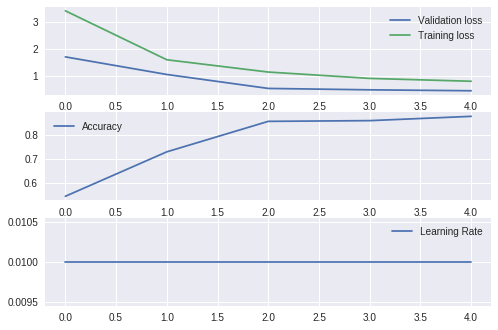

Epoch 6 , Batch 25/236 Loss:0.9493067860603333 Running time Epoch: 36.807 s, Running Time: 1742.416 s
Epoch 6 , Batch 50/236 Loss:1.2146738767623901 Running time Epoch: 71.029 s, Running Time: 1776.638 s
Epoch 6 , Batch 75/236 Loss:0.6113131642341614 Running time Epoch: 105.271 s, Running Time: 1810.880 s
Epoch 6 , Batch 100/236 Loss:0.7885698080062866 Running time Epoch: 139.534 s, Running Time: 1845.142 s
Epoch 6 , Batch 125/236 Loss:0.3936433792114258 Running time Epoch: 173.822 s, Running Time: 1879.431 s
Epoch 6 , Batch 150/236 Loss:0.7014715671539307 Running time Epoch: 208.101 s, Running Time: 1913.710 s
Epoch 6 , Batch 175/236 Loss:0.8336805701255798 Running time Epoch: 242.386 s, Running Time: 1947.995 s
Epoch 6 , Batch 200/236 Loss:0.6252696514129639 Running time Epoch: 276.658 s, Running Time: 1982.267 s
Epoch 6 , Batch 225/236 Loss:0.5673233270645142 Running time Epoch: 310.950 s, Running Time: 2016.558 s
======>Epoch 6 Finished , TLoss:0.7033228783915608 VLoss :0.320224995

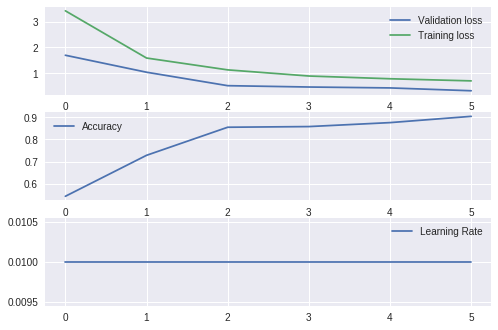

Epoch 7 , Batch 25/236 Loss:0.8286287188529968 Running time Epoch: 36.789 s, Running Time: 2083.347 s
Epoch 7 , Batch 50/236 Loss:0.5734114050865173 Running time Epoch: 71.028 s, Running Time: 2117.586 s
Epoch 7 , Batch 75/236 Loss:0.6526581048965454 Running time Epoch: 105.290 s, Running Time: 2151.848 s
Epoch 7 , Batch 100/236 Loss:0.4563022255897522 Running time Epoch: 139.577 s, Running Time: 2186.135 s
Epoch 7 , Batch 125/236 Loss:0.8408743143081665 Running time Epoch: 173.824 s, Running Time: 2220.382 s
Epoch 7 , Batch 150/236 Loss:0.4762827754020691 Running time Epoch: 208.090 s, Running Time: 2254.648 s
Epoch 7 , Batch 175/236 Loss:0.42600974440574646 Running time Epoch: 242.382 s, Running Time: 2288.940 s
Epoch 7 , Batch 200/236 Loss:0.5129653811454773 Running time Epoch: 276.630 s, Running Time: 2323.188 s
Epoch 7 , Batch 225/236 Loss:0.42635414004325867 Running time Epoch: 310.929 s, Running Time: 2357.487 s
======>Epoch 7 Finished , TLoss:0.5919488150058156 VLoss :0.2700873

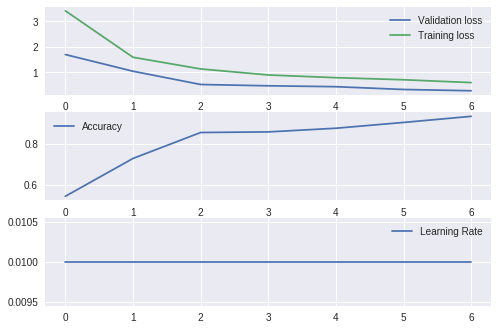

Epoch 8 , Batch 25/236 Loss:1.1702302694320679 Running time Epoch: 36.592 s, Running Time: 2424.092 s
Epoch 8 , Batch 50/236 Loss:0.34694305062294006 Running time Epoch: 70.810 s, Running Time: 2458.311 s
Epoch 8 , Batch 75/236 Loss:0.30307385325431824 Running time Epoch: 105.088 s, Running Time: 2492.588 s
Epoch 8 , Batch 100/236 Loss:0.5390538573265076 Running time Epoch: 139.405 s, Running Time: 2526.906 s
Epoch 8 , Batch 125/236 Loss:0.9182321429252625 Running time Epoch: 173.756 s, Running Time: 2561.257 s
Epoch 8 , Batch 150/236 Loss:0.5634567737579346 Running time Epoch: 208.036 s, Running Time: 2595.537 s
Epoch 8 , Batch 175/236 Loss:0.14420729875564575 Running time Epoch: 242.323 s, Running Time: 2629.823 s
Epoch 8 , Batch 200/236 Loss:0.4743669927120209 Running time Epoch: 276.650 s, Running Time: 2664.150 s
Epoch 8 , Batch 225/236 Loss:0.37849196791648865 Running time Epoch: 310.928 s, Running Time: 2698.429 s
======>Epoch 8 Finished , TLoss:0.5686635252530292 VLoss :0.32382

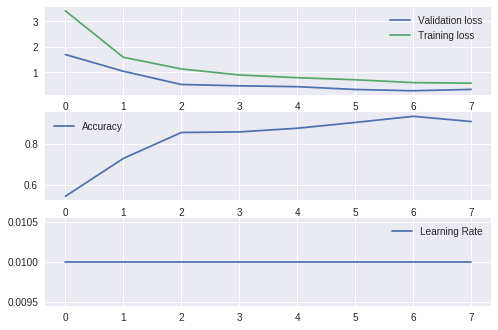

Epoch 9 , Batch 25/236 Loss:0.9135938882827759 Running time Epoch: 36.812 s, Running Time: 2764.475 s
Epoch 9 , Batch 50/236 Loss:0.5305793285369873 Running time Epoch: 71.074 s, Running Time: 2798.736 s
Epoch 9 , Batch 75/236 Loss:0.8472995162010193 Running time Epoch: 105.326 s, Running Time: 2832.988 s
Epoch 9 , Batch 100/236 Loss:0.14865325391292572 Running time Epoch: 139.630 s, Running Time: 2867.292 s
Epoch 9 , Batch 125/236 Loss:0.10472442954778671 Running time Epoch: 173.919 s, Running Time: 2901.581 s
Epoch 9 , Batch 150/236 Loss:0.505623459815979 Running time Epoch: 208.214 s, Running Time: 2935.876 s
Epoch 9 , Batch 175/236 Loss:0.6038447618484497 Running time Epoch: 242.495 s, Running Time: 2970.157 s
Epoch 9 , Batch 200/236 Loss:0.2843092679977417 Running time Epoch: 276.789 s, Running Time: 3004.451 s
Epoch 9 , Batch 225/236 Loss:0.5408734679222107 Running time Epoch: 311.063 s, Running Time: 3038.725 s
======>Epoch 9 Finished , TLoss:0.5269223529435063 VLoss :0.29630997

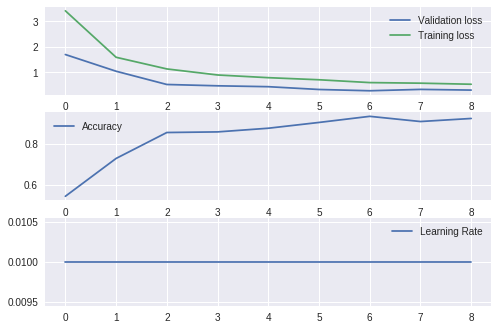

Epoch 10 , Batch 25/236 Loss:0.42970162630081177 Running time Epoch: 36.587 s, Running Time: 3104.972 s
Epoch 10 , Batch 50/236 Loss:0.7610414028167725 Running time Epoch: 70.816 s, Running Time: 3139.201 s
Epoch 10 , Batch 75/236 Loss:0.5717557668685913 Running time Epoch: 105.045 s, Running Time: 3173.429 s
Epoch 10 , Batch 100/236 Loss:0.36563122272491455 Running time Epoch: 139.289 s, Running Time: 3207.673 s
Epoch 10 , Batch 125/236 Loss:0.9913319945335388 Running time Epoch: 173.548 s, Running Time: 3241.933 s
Epoch 10 , Batch 150/236 Loss:1.1963012218475342 Running time Epoch: 207.814 s, Running Time: 3276.199 s
Epoch 10 , Batch 175/236 Loss:0.8964773416519165 Running time Epoch: 242.097 s, Running Time: 3310.482 s
Epoch 10 , Batch 200/236 Loss:0.8050041198730469 Running time Epoch: 276.381 s, Running Time: 3344.766 s
Epoch 10 , Batch 225/236 Loss:0.27541160583496094 Running time Epoch: 310.660 s, Running Time: 3379.045 s
======>Epoch 10 Finished , TLoss:0.49817986328596786 VLos

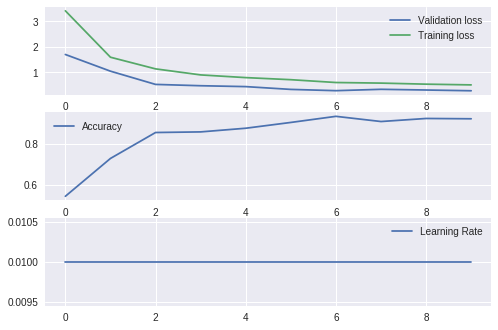

Epoch 11 , Batch 25/236 Loss:0.28411492705345154 Running time Epoch: 36.764 s, Running Time: 3446.007 s
Epoch 11 , Batch 50/236 Loss:0.25701287388801575 Running time Epoch: 70.985 s, Running Time: 3480.228 s
Epoch 11 , Batch 75/236 Loss:0.593214213848114 Running time Epoch: 105.228 s, Running Time: 3514.471 s
Epoch 11 , Batch 100/236 Loss:0.557094395160675 Running time Epoch: 139.498 s, Running Time: 3548.741 s
Epoch 11 , Batch 125/236 Loss:0.27528804540634155 Running time Epoch: 173.803 s, Running Time: 3583.046 s
Epoch 11 , Batch 150/236 Loss:0.9045514464378357 Running time Epoch: 208.052 s, Running Time: 3617.295 s
Epoch 11 , Batch 175/236 Loss:0.40062689781188965 Running time Epoch: 242.327 s, Running Time: 3651.570 s
Epoch 11 , Batch 200/236 Loss:0.2804790437221527 Running time Epoch: 276.596 s, Running Time: 3685.839 s
Epoch 11 , Batch 225/236 Loss:0.3193351626396179 Running time Epoch: 310.870 s, Running Time: 3720.113 s
======>Epoch 11 Finished , TLoss:0.4420430406738641 VLoss 

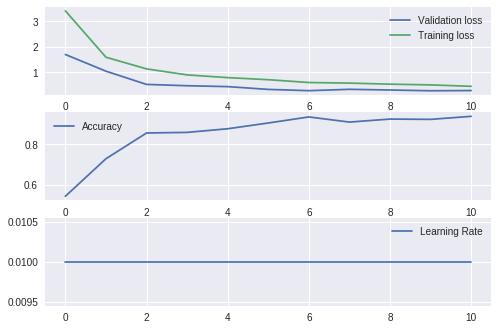

Epoch 12 , Batch 25/236 Loss:0.14452002942562103 Running time Epoch: 36.674 s, Running Time: 3786.242 s
Epoch 12 , Batch 50/236 Loss:0.49380168318748474 Running time Epoch: 70.875 s, Running Time: 3820.442 s
Epoch 12 , Batch 75/236 Loss:0.18757282197475433 Running time Epoch: 105.100 s, Running Time: 3854.667 s
Epoch 12 , Batch 100/236 Loss:0.30494681000709534 Running time Epoch: 139.367 s, Running Time: 3888.935 s
Epoch 12 , Batch 125/236 Loss:0.2253173291683197 Running time Epoch: 173.634 s, Running Time: 3923.202 s
Epoch 12 , Batch 150/236 Loss:0.5758136510848999 Running time Epoch: 207.920 s, Running Time: 3957.488 s
Epoch 12 , Batch 175/236 Loss:0.0857929065823555 Running time Epoch: 242.194 s, Running Time: 3991.762 s
Epoch 12 , Batch 200/236 Loss:0.5542793273925781 Running time Epoch: 276.494 s, Running Time: 4026.062 s
Epoch 12 , Batch 225/236 Loss:0.3242589235305786 Running time Epoch: 310.736 s, Running Time: 4060.304 s
======>Epoch 12 Finished , TLoss:0.43927285376683634 VLo

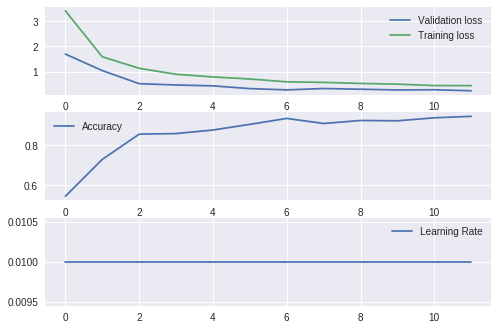

Epoch 13 , Batch 25/236 Loss:0.4247216284275055 Running time Epoch: 36.965 s, Running Time: 4127.433 s
Epoch 13 , Batch 50/236 Loss:0.37559178471565247 Running time Epoch: 71.217 s, Running Time: 4161.685 s
Epoch 13 , Batch 75/236 Loss:0.9503436088562012 Running time Epoch: 105.489 s, Running Time: 4195.957 s
Epoch 13 , Batch 100/236 Loss:0.2985849678516388 Running time Epoch: 139.770 s, Running Time: 4230.238 s
Epoch 13 , Batch 125/236 Loss:0.2177441418170929 Running time Epoch: 174.084 s, Running Time: 4264.551 s
Epoch 13 , Batch 150/236 Loss:0.5056800246238708 Running time Epoch: 208.414 s, Running Time: 4298.882 s
Epoch 13 , Batch 175/236 Loss:0.43957415223121643 Running time Epoch: 242.693 s, Running Time: 4333.161 s
Epoch 13 , Batch 200/236 Loss:0.5252044200897217 Running time Epoch: 276.984 s, Running Time: 4367.452 s
Epoch 13 , Batch 225/236 Loss:0.6161430478096008 Running time Epoch: 311.244 s, Running Time: 4401.711 s
======>Epoch 13 Finished , TLoss:0.41461585913548027 VLoss

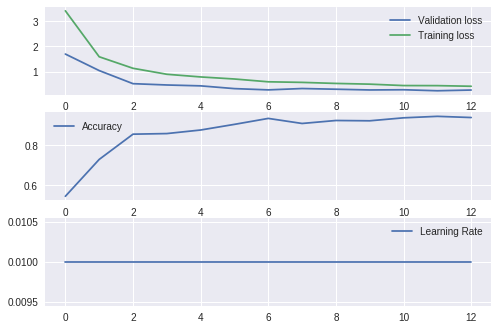

Epoch 14 , Batch 25/236 Loss:0.32942503690719604 Running time Epoch: 36.858 s, Running Time: 4468.209 s
Epoch 14 , Batch 50/236 Loss:0.14517250657081604 Running time Epoch: 71.066 s, Running Time: 4502.417 s
Epoch 14 , Batch 75/236 Loss:0.288387268781662 Running time Epoch: 105.330 s, Running Time: 4536.680 s
Epoch 14 , Batch 100/236 Loss:0.5103767514228821 Running time Epoch: 139.636 s, Running Time: 4570.986 s
Epoch 14 , Batch 125/236 Loss:0.9413692951202393 Running time Epoch: 173.956 s, Running Time: 4605.306 s
Epoch 14 , Batch 150/236 Loss:0.6816055774688721 Running time Epoch: 208.257 s, Running Time: 4639.608 s
Epoch 14 , Batch 175/236 Loss:0.17235851287841797 Running time Epoch: 242.553 s, Running Time: 4673.904 s
Epoch 14 , Batch 200/236 Loss:0.6316205859184265 Running time Epoch: 276.855 s, Running Time: 4708.205 s
Epoch 14 , Batch 225/236 Loss:0.2287534922361374 Running time Epoch: 311.130 s, Running Time: 4742.480 s
======>Epoch 14 Finished , TLoss:0.4072770967890145 VLoss 

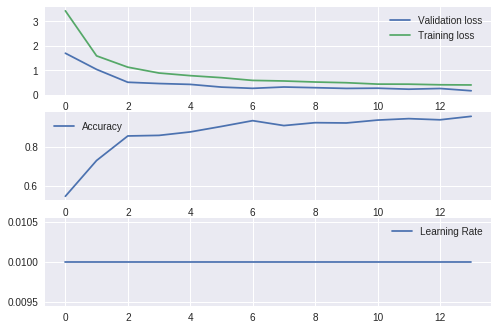

Epoch 15 , Batch 25/236 Loss:0.1883012354373932 Running time Epoch: 36.983 s, Running Time: 4809.483 s
Epoch 15 , Batch 50/236 Loss:0.1980428695678711 Running time Epoch: 71.189 s, Running Time: 4843.689 s
Epoch 15 , Batch 75/236 Loss:0.591335117816925 Running time Epoch: 105.452 s, Running Time: 4877.952 s
Epoch 15 , Batch 100/236 Loss:0.13801728188991547 Running time Epoch: 139.702 s, Running Time: 4912.202 s
Epoch 15 , Batch 125/236 Loss:0.5183622241020203 Running time Epoch: 173.979 s, Running Time: 4946.479 s
Epoch 15 , Batch 150/236 Loss:0.2534472942352295 Running time Epoch: 208.261 s, Running Time: 4980.761 s
Epoch 15 , Batch 175/236 Loss:0.5853888392448425 Running time Epoch: 242.530 s, Running Time: 5015.030 s
Epoch 15 , Batch 200/236 Loss:0.10042642802000046 Running time Epoch: 276.832 s, Running Time: 5049.332 s
Epoch 15 , Batch 225/236 Loss:0.08211677521467209 Running time Epoch: 311.114 s, Running Time: 5083.614 s
======>Epoch 15 Finished , TLoss:0.35136289994816405 VLoss

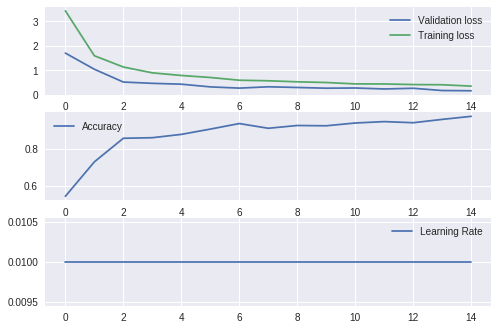

Epoch 16 , Batch 25/236 Loss:0.047007981687784195 Running time Epoch: 36.791 s, Running Time: 5150.821 s
Epoch 16 , Batch 50/236 Loss:0.27224546670913696 Running time Epoch: 71.024 s, Running Time: 5185.055 s
Epoch 16 , Batch 75/236 Loss:0.3281005024909973 Running time Epoch: 105.285 s, Running Time: 5219.315 s
Epoch 16 , Batch 100/236 Loss:0.15705843269824982 Running time Epoch: 139.547 s, Running Time: 5253.577 s
Epoch 16 , Batch 125/236 Loss:0.15744170546531677 Running time Epoch: 173.807 s, Running Time: 5287.838 s
Epoch 16 , Batch 150/236 Loss:0.09861404448747635 Running time Epoch: 208.106 s, Running Time: 5322.136 s
Epoch 16 , Batch 175/236 Loss:1.3247134685516357 Running time Epoch: 242.358 s, Running Time: 5356.389 s
Epoch 16 , Batch 200/236 Loss:0.22108310461044312 Running time Epoch: 276.632 s, Running Time: 5390.663 s
Epoch 16 , Batch 225/236 Loss:0.30004411935806274 Running time Epoch: 310.911 s, Running Time: 5424.942 s
======>Epoch 16 Finished , TLoss:0.3934092759154737 

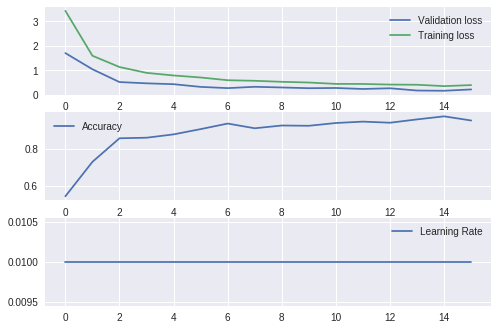

Epoch 17 , Batch 25/236 Loss:0.34093084931373596 Running time Epoch: 36.662 s, Running Time: 5491.334 s
Epoch 17 , Batch 50/236 Loss:0.8218656182289124 Running time Epoch: 70.893 s, Running Time: 5525.565 s
Epoch 17 , Batch 75/236 Loss:0.47153550386428833 Running time Epoch: 105.127 s, Running Time: 5559.799 s
Epoch 17 , Batch 100/236 Loss:0.48425155878067017 Running time Epoch: 139.387 s, Running Time: 5594.059 s
Epoch 17 , Batch 125/236 Loss:0.31874462962150574 Running time Epoch: 173.638 s, Running Time: 5628.310 s
Epoch 17 , Batch 150/236 Loss:0.32270926237106323 Running time Epoch: 207.920 s, Running Time: 5662.593 s
Epoch 17 , Batch 175/236 Loss:0.2731937766075134 Running time Epoch: 242.165 s, Running Time: 5696.837 s
Epoch 17 , Batch 200/236 Loss:0.06673017144203186 Running time Epoch: 276.449 s, Running Time: 5731.121 s
Epoch 17 , Batch 225/236 Loss:0.500552237033844 Running time Epoch: 310.732 s, Running Time: 5765.405 s
======>Epoch 17 Finished , TLoss:0.36141050065338803 VL

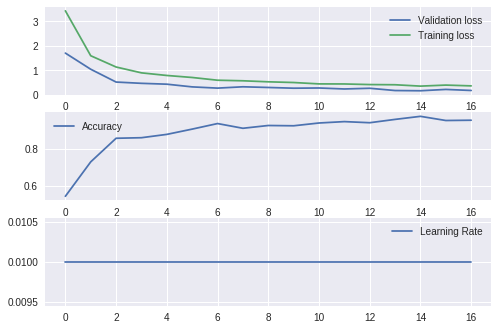

Epoch 18 , Batch 25/236 Loss:0.014253959991037846 Running time Epoch: 36.757 s, Running Time: 5831.707 s
Epoch 18 , Batch 50/236 Loss:0.35612377524375916 Running time Epoch: 70.961 s, Running Time: 5865.911 s
Epoch 18 , Batch 75/236 Loss:0.05553707107901573 Running time Epoch: 105.194 s, Running Time: 5900.144 s
Epoch 18 , Batch 100/236 Loss:0.43423396348953247 Running time Epoch: 139.457 s, Running Time: 5934.407 s
Epoch 18 , Batch 125/236 Loss:0.9975616931915283 Running time Epoch: 173.736 s, Running Time: 5968.686 s
Epoch 18 , Batch 150/236 Loss:0.508983850479126 Running time Epoch: 208.017 s, Running Time: 6002.967 s
Epoch 18 , Batch 175/236 Loss:0.8238645195960999 Running time Epoch: 242.277 s, Running Time: 6037.227 s
Epoch 18 , Batch 200/236 Loss:0.3018367290496826 Running time Epoch: 276.558 s, Running Time: 6071.508 s
Epoch 18 , Batch 225/236 Loss:0.6662625074386597 Running time Epoch: 310.817 s, Running Time: 6105.767 s
======>Epoch 18 Finished , TLoss:0.34483815831037523 VLo

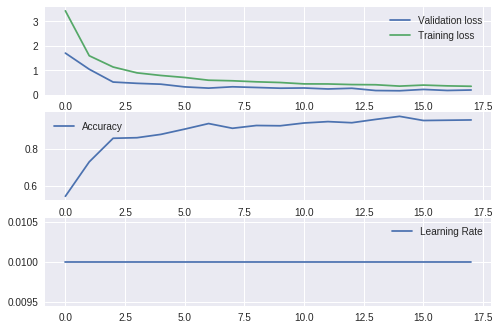

Epoch 19 , Batch 25/236 Loss:0.664136528968811 Running time Epoch: 36.965 s, Running Time: 6172.333 s
Epoch 19 , Batch 50/236 Loss:0.2642248272895813 Running time Epoch: 71.171 s, Running Time: 6206.539 s
Epoch 19 , Batch 75/236 Loss:0.10467327386140823 Running time Epoch: 105.408 s, Running Time: 6240.776 s
Epoch 19 , Batch 100/236 Loss:0.3638628423213959 Running time Epoch: 139.650 s, Running Time: 6275.018 s
Epoch 19 , Batch 125/236 Loss:0.4665714204311371 Running time Epoch: 173.922 s, Running Time: 6309.290 s
Epoch 19 , Batch 150/236 Loss:0.4003799557685852 Running time Epoch: 208.201 s, Running Time: 6343.568 s
Epoch 19 , Batch 175/236 Loss:0.5402418971061707 Running time Epoch: 242.495 s, Running Time: 6377.863 s
Epoch 19 , Batch 200/236 Loss:0.14044834673404694 Running time Epoch: 276.811 s, Running Time: 6412.179 s
Epoch 19 , Batch 225/236 Loss:0.43678706884384155 Running time Epoch: 311.089 s, Running Time: 6446.456 s
======>Epoch 19 Finished , TLoss:0.30016921877849184 VLoss

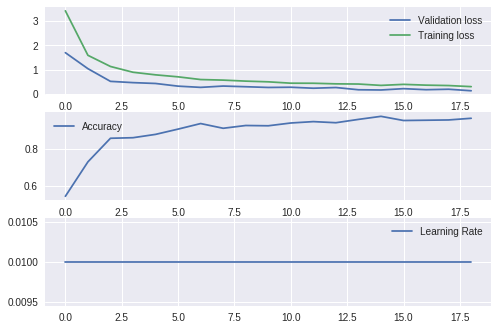

Epoch 20 , Batch 25/236 Loss:0.13626185059547424 Running time Epoch: 36.920 s, Running Time: 6513.781 s
Epoch 20 , Batch 50/236 Loss:0.05318614840507507 Running time Epoch: 71.115 s, Running Time: 6547.975 s
Epoch 20 , Batch 75/236 Loss:0.27666473388671875 Running time Epoch: 105.373 s, Running Time: 6582.233 s
Epoch 20 , Batch 100/236 Loss:0.02651359513401985 Running time Epoch: 139.599 s, Running Time: 6616.459 s
Epoch 20 , Batch 125/236 Loss:0.0312153622508049 Running time Epoch: 173.883 s, Running Time: 6650.743 s
Epoch 20 , Batch 150/236 Loss:0.1684856414794922 Running time Epoch: 208.192 s, Running Time: 6685.052 s
Epoch 20 , Batch 175/236 Loss:0.45861193537712097 Running time Epoch: 242.489 s, Running Time: 6719.349 s
Epoch 20 , Batch 200/236 Loss:0.21719379723072052 Running time Epoch: 276.776 s, Running Time: 6753.636 s
Epoch 20 , Batch 225/236 Loss:0.2470940798521042 Running time Epoch: 311.047 s, Running Time: 6787.908 s
======>Epoch 20 Finished , TLoss:0.316217421861839 VLo

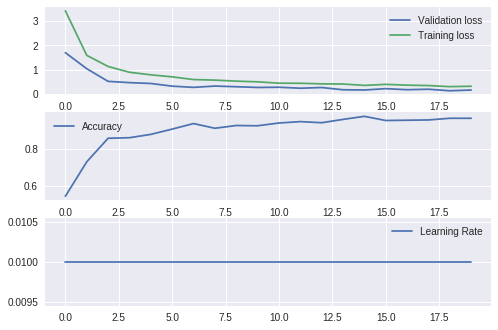

Epoch 21 , Batch 25/236 Loss:0.1738033890724182 Running time Epoch: 36.751 s, Running Time: 6854.174 s
Epoch 21 , Batch 50/236 Loss:0.08448512852191925 Running time Epoch: 70.956 s, Running Time: 6888.380 s
Epoch 21 , Batch 75/236 Loss:0.3697696626186371 Running time Epoch: 105.207 s, Running Time: 6922.631 s
Epoch 21 , Batch 100/236 Loss:0.8452466726303101 Running time Epoch: 139.471 s, Running Time: 6956.894 s
Epoch 21 , Batch 125/236 Loss:0.1447952687740326 Running time Epoch: 173.721 s, Running Time: 6991.144 s
Epoch 21 , Batch 150/236 Loss:0.21717652678489685 Running time Epoch: 207.997 s, Running Time: 7025.421 s
Epoch 21 , Batch 175/236 Loss:0.35083121061325073 Running time Epoch: 242.275 s, Running Time: 7059.699 s
Epoch 21 , Batch 200/236 Loss:0.3482637107372284 Running time Epoch: 276.565 s, Running Time: 7093.989 s
Epoch 21 , Batch 225/236 Loss:0.20164279639720917 Running time Epoch: 310.847 s, Running Time: 7128.271 s
======>Epoch 21 Finished , TLoss:0.2969647413514302 VLos

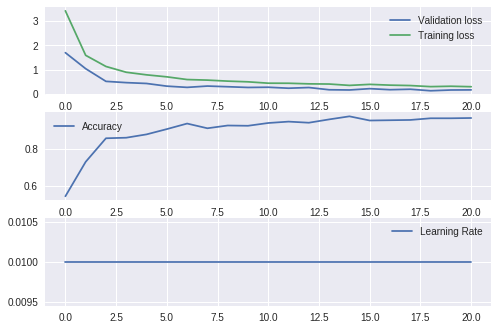

Epoch 22 , Batch 25/236 Loss:0.30848991870880127 Running time Epoch: 36.733 s, Running Time: 7194.594 s
Epoch 22 , Batch 50/236 Loss:0.23608610033988953 Running time Epoch: 70.986 s, Running Time: 7228.848 s
Epoch 22 , Batch 75/236 Loss:0.025369606912136078 Running time Epoch: 105.245 s, Running Time: 7263.106 s
Epoch 22 , Batch 100/236 Loss:0.2323027104139328 Running time Epoch: 139.546 s, Running Time: 7297.407 s
Epoch 22 , Batch 125/236 Loss:0.26356661319732666 Running time Epoch: 173.829 s, Running Time: 7331.691 s
Epoch 22 , Batch 150/236 Loss:0.6060986518859863 Running time Epoch: 208.113 s, Running Time: 7365.975 s
Epoch 22 , Batch 175/236 Loss:0.13212387263774872 Running time Epoch: 242.391 s, Running Time: 7400.252 s
Epoch 22 , Batch 200/236 Loss:0.36661258339881897 Running time Epoch: 276.640 s, Running Time: 7434.501 s
Epoch 22 , Batch 225/236 Loss:0.1435372531414032 Running time Epoch: 310.851 s, Running Time: 7468.712 s
======>Epoch 22 Finished , TLoss:0.3149871987298573 V

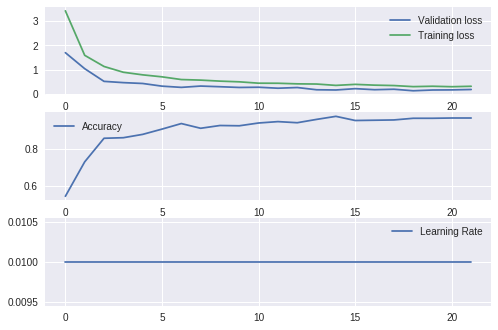

Epoch 23 , Batch 25/236 Loss:0.16360703110694885 Running time Epoch: 36.847 s, Running Time: 7535.241 s
Epoch 23 , Batch 50/236 Loss:0.45144423842430115 Running time Epoch: 71.075 s, Running Time: 7569.468 s
Epoch 23 , Batch 75/236 Loss:0.5297737121582031 Running time Epoch: 105.356 s, Running Time: 7603.750 s
Epoch 23 , Batch 100/236 Loss:0.30756676197052 Running time Epoch: 139.661 s, Running Time: 7638.054 s
Epoch 23 , Batch 125/236 Loss:0.06867160648107529 Running time Epoch: 173.955 s, Running Time: 7672.348 s
Epoch 23 , Batch 150/236 Loss:0.6543380618095398 Running time Epoch: 208.218 s, Running Time: 7706.612 s
Epoch 23 , Batch 175/236 Loss:0.5509626865386963 Running time Epoch: 242.482 s, Running Time: 7740.875 s
Epoch 23 , Batch 200/236 Loss:0.24570035934448242 Running time Epoch: 276.725 s, Running Time: 7775.119 s
Epoch 23 , Batch 225/236 Loss:0.6787292957305908 Running time Epoch: 310.980 s, Running Time: 7809.373 s
======>Epoch 23 Finished , TLoss:0.28028192036534594 VLoss

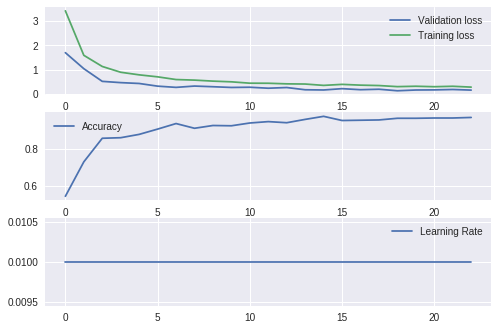

Epoch 24 , Batch 25/236 Loss:0.1301153600215912 Running time Epoch: 36.772 s, Running Time: 7875.978 s
Epoch 24 , Batch 50/236 Loss:0.18800461292266846 Running time Epoch: 70.989 s, Running Time: 7910.195 s
Epoch 24 , Batch 75/236 Loss:0.3588745594024658 Running time Epoch: 105.260 s, Running Time: 7944.466 s
Epoch 24 , Batch 100/236 Loss:0.5084658265113831 Running time Epoch: 139.529 s, Running Time: 7978.734 s
Epoch 24 , Batch 125/236 Loss:1.0598995685577393 Running time Epoch: 173.843 s, Running Time: 8013.048 s
Epoch 24 , Batch 150/236 Loss:0.2333163022994995 Running time Epoch: 208.126 s, Running Time: 8047.331 s
Epoch 24 , Batch 175/236 Loss:0.111261747777462 Running time Epoch: 242.402 s, Running Time: 8081.607 s
Epoch 24 , Batch 200/236 Loss:0.3927415609359741 Running time Epoch: 276.684 s, Running Time: 8115.889 s
Epoch 24 , Batch 225/236 Loss:0.4907059371471405 Running time Epoch: 310.952 s, Running Time: 8150.157 s
======>Epoch 24 Finished , TLoss:0.3170211489205801 VLoss :0

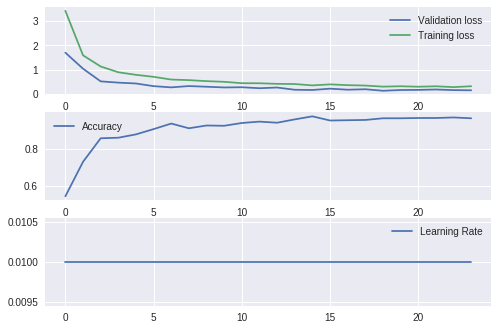

Epoch 25 , Batch 25/236 Loss:0.14674460887908936 Running time Epoch: 36.696 s, Running Time: 8216.270 s


In [0]:
trainCEL(model,80,train_loader,valid_loader,learning_rate=0.01,opt="SGD",freeze=False,N_EPOCHS_TO_UNFREEZE=30)

In [0]:
! dir

cat_to_name.json  flower_data  flower_data.zip	gdrive	null  sample_data


# Testing 

In [14]:
model=model.cuda()
model.eval()
chpt=load_model("gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.999.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 0.13821972249205575 Testing_accuracy : 0.9793938398361206


In [15]:

model=model.cuda()
model.eval()
chpt=load_model("gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.999.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 0.13821972249205575 Testing_accuracy : 0.9793938398361206


# Testing error for each class
## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
train_on_gpu=True
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %2d %5s: %2d%% (%2d/%2d)' % (i+1,
            cat_to_name["{}".format(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (cat_to_name["{}".format(i+1)]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.139360

Test Accuracy of  1 pink primrose: 100% ( 8/ 8)
Test Accuracy of  2 hard-leaved pocket orchid: 100% ( 4/ 4)
Test Accuracy of  3 canterbury bells: 100% ( 6/ 6)
Test Accuracy of  4 sweet pea: 100% ( 5/ 5)
Test Accuracy of  5 english marigold: 100% ( 6/ 6)
Test Accuracy of  6 tiger lily: 100% (10/10)
Test Accuracy of  7 moon orchid: 100% ( 5/ 5)
Test Accuracy of  8 bird of paradise: 80% ( 4/ 5)
Test Accuracy of  9 monkshood: 100% ( 1/ 1)
Test Accuracy of 10 globe thistle: 100% ( 7/ 7)
Test Accuracy of 11 snapdragon: 100% ( 2/ 2)
Test Accuracy of 12 colt's foot: 100% (16/16)
Test Accuracy of 13 king protea: 100% (11/11)
Test Accuracy of 14 spear thistle: 100% ( 4/ 4)
Test Accuracy of 15 yellow iris: 100% ( 6/ 6)
Test Accuracy of 16 globe-flower: 85% ( 6/ 7)
Test Accuracy of 17 purple coneflower: 100% ( 4/ 4)
Test Accuracy of 18 peruvian lily: 100% ( 8/ 8)
Test Accuracy of 19 balloon flower: 100% (12/12)
Test Accuracy of 20 giant white arum lily: 100% ( 5/ 5)
Test Accur

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

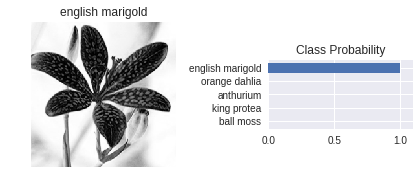

In [17]:
import numpy as np
def view_classify(img, ps,labels,k,title):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(k), ps)
    ax1.set_title(title)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(k))
    ax2.set_yticklabels(labels, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
dataiter = iter(test_loader)
dataiter.next()
images, labels = dataiter.next()
images,labels = images.cuda(),labels.cuda()
idx=0
img = images[idx].cpu()
lbl=labels[idx].cpu()

ps=torch.softmax(model(images),dim=1)
top_p,top_c= ps.topk(5,dim=1)

top_p,top_c=top_p[idx].cpu(),top_c[idx].cpu()

ll=[]
for a in top_c:
  ll.append(cat_to_name["{}".format(a.item()+1)])
ll=ll[::-1]

inv_idx = torch.arange(top_p.size(0)-1, -1, -1).long()
top_p = top_p[inv_idx]

view_classify(img,top_p,ll,5,cat_to_name["{}".format(lbl.item()+1)])

## Training Second Time

Epoch 1 , Batch 25/236 Loss:0.20628178119659424 Running time Epoch: 17.758 s, Running Time: 17.758 s
Epoch 1 , Batch 50/236 Loss:0.1983722299337387 Running time Epoch: 33.574 s, Running Time: 33.574 s
Epoch 1 , Batch 75/236 Loss:0.8945637345314026 Running time Epoch: 48.802 s, Running Time: 48.802 s
Epoch 1 , Batch 100/236 Loss:0.08172771334648132 Running time Epoch: 64.443 s, Running Time: 64.443 s
Epoch 1 , Batch 125/236 Loss:0.18041987717151642 Running time Epoch: 80.113 s, Running Time: 80.113 s
Epoch 1 , Batch 150/236 Loss:0.05153056979179382 Running time Epoch: 96.720 s, Running Time: 96.720 s
Epoch 1 , Batch 175/236 Loss:0.4419533610343933 Running time Epoch: 112.043 s, Running Time: 112.043 s
Epoch 1 , Batch 200/236 Loss:0.2901853621006012 Running time Epoch: 127.112 s, Running Time: 127.112 s
Epoch 1 , Batch 225/236 Loss:0.031571730971336365 Running time Epoch: 142.664 s, Running Time: 142.664 s
======>Epoch 1 Finished , TLoss:0.17025085429215045 VLoss :0.008054504578442194 Ac

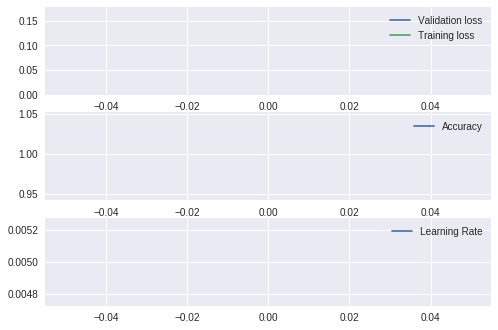

Epoch 2 , Batch 25/236 Loss:0.08543174713850021 Running time Epoch: 17.884 s, Running Time: 182.180 s
Epoch 2 , Batch 50/236 Loss:0.03774242475628853 Running time Epoch: 33.805 s, Running Time: 198.101 s
Epoch 2 , Batch 75/236 Loss:0.19579465687274933 Running time Epoch: 49.294 s, Running Time: 213.590 s
Epoch 2 , Batch 100/236 Loss:0.21971894800662994 Running time Epoch: 64.718 s, Running Time: 229.014 s
Epoch 2 , Batch 125/236 Loss:0.1107265055179596 Running time Epoch: 80.995 s, Running Time: 245.291 s
Epoch 2 , Batch 150/236 Loss:0.016568146646022797 Running time Epoch: 96.533 s, Running Time: 260.829 s
Epoch 2 , Batch 175/236 Loss:0.1658346951007843 Running time Epoch: 111.678 s, Running Time: 275.974 s
Epoch 2 , Batch 200/236 Loss:0.03946760296821594 Running time Epoch: 127.154 s, Running Time: 291.450 s
Epoch 2 , Batch 225/236 Loss:0.24089883267879486 Running time Epoch: 142.754 s, Running Time: 307.050 s
======>Epoch 2 Finished , TLoss:0.15780594033732717 VLoss :0.0071350640512

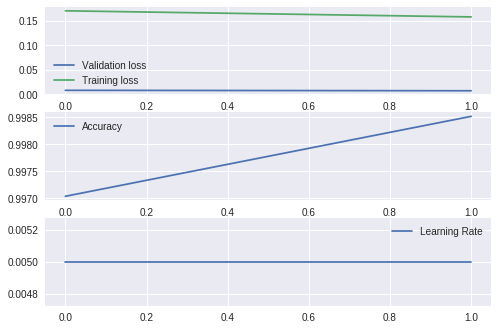

Epoch 3 , Batch 25/236 Loss:0.15035846829414368 Running time Epoch: 19.317 s, Running Time: 348.170 s
Epoch 3 , Batch 50/236 Loss:0.1611817330121994 Running time Epoch: 35.111 s, Running Time: 363.964 s
Epoch 3 , Batch 75/236 Loss:0.10465101152658463 Running time Epoch: 50.515 s, Running Time: 379.368 s
Epoch 3 , Batch 100/236 Loss:0.3053288161754608 Running time Epoch: 66.326 s, Running Time: 395.179 s
Epoch 3 , Batch 125/236 Loss:0.2129439413547516 Running time Epoch: 82.424 s, Running Time: 411.278 s
Epoch 3 , Batch 150/236 Loss:0.012417621910572052 Running time Epoch: 97.839 s, Running Time: 426.692 s
Epoch 3 , Batch 175/236 Loss:0.2799384891986847 Running time Epoch: 113.648 s, Running Time: 442.502 s
Epoch 3 , Batch 200/236 Loss:0.02542751282453537 Running time Epoch: 128.421 s, Running Time: 457.275 s
Epoch 3 , Batch 225/236 Loss:0.15871043503284454 Running time Epoch: 144.275 s, Running Time: 473.128 s
======>Epoch 3 Finished , TLoss:0.1621353536275989 VLoss :0.0142710297989323

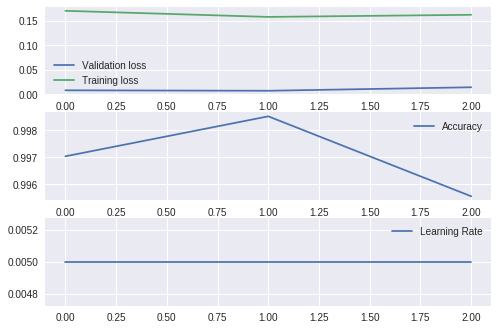

Epoch 4 , Batch 25/236 Loss:0.17733190953731537 Running time Epoch: 18.065 s, Running Time: 511.266 s
Epoch 4 , Batch 50/236 Loss:0.012044982984662056 Running time Epoch: 33.995 s, Running Time: 527.196 s
Epoch 4 , Batch 75/236 Loss:0.3838157653808594 Running time Epoch: 49.524 s, Running Time: 542.725 s
Epoch 4 , Batch 100/236 Loss:0.12333625555038452 Running time Epoch: 64.917 s, Running Time: 558.118 s
Epoch 4 , Batch 125/236 Loss:0.17729847133159637 Running time Epoch: 81.160 s, Running Time: 574.361 s
Epoch 4 , Batch 150/236 Loss:0.20206569135189056 Running time Epoch: 96.401 s, Running Time: 589.602 s
Epoch 4 , Batch 175/236 Loss:0.02578781172633171 Running time Epoch: 112.194 s, Running Time: 605.395 s
Epoch 4 , Batch 200/236 Loss:0.0900757759809494 Running time Epoch: 127.494 s, Running Time: 620.695 s
Epoch 4 , Batch 225/236 Loss:0.48439690470695496 Running time Epoch: 143.736 s, Running Time: 636.937 s
======>Epoch 4 Finished , TLoss:0.1659771134303409 VLoss :0.01106556218584

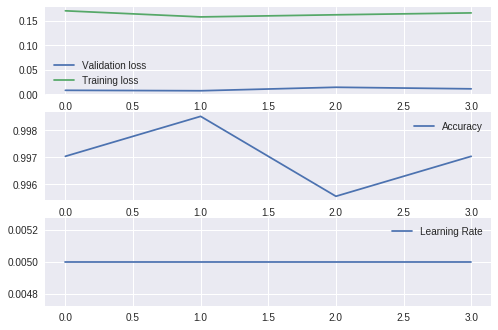

Epoch 5 , Batch 25/236 Loss:0.477786660194397 Running time Epoch: 17.970 s, Running Time: 675.206 s
Epoch 5 , Batch 50/236 Loss:0.11362922936677933 Running time Epoch: 33.607 s, Running Time: 690.843 s
Epoch 5 , Batch 75/236 Loss:0.38192158937454224 Running time Epoch: 49.495 s, Running Time: 706.731 s
Epoch 5 , Batch 100/236 Loss:0.017711525782942772 Running time Epoch: 64.982 s, Running Time: 722.218 s
Epoch 5 , Batch 125/236 Loss:0.0794091448187828 Running time Epoch: 81.080 s, Running Time: 738.316 s
Epoch 5 , Batch 150/236 Loss:0.05509757995605469 Running time Epoch: 96.859 s, Running Time: 754.095 s
Epoch 5 , Batch 175/236 Loss:0.005024223122745752 Running time Epoch: 112.459 s, Running Time: 769.695 s
Epoch 5 , Batch 200/236 Loss:0.053301773965358734 Running time Epoch: 127.652 s, Running Time: 784.888 s
Epoch 5 , Batch 225/236 Loss:0.1296519637107849 Running time Epoch: 143.894 s, Running Time: 801.131 s
======>Epoch 5 Finished , TLoss:0.14991100219271236 VLoss :0.0086989878397

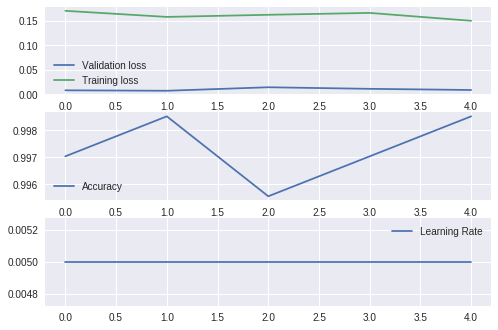

Epoch 6 , Batch 25/236 Loss:0.034867096692323685 Running time Epoch: 17.613 s, Running Time: 839.430 s
Epoch 6 , Batch 50/236 Loss:0.13010132312774658 Running time Epoch: 33.679 s, Running Time: 855.495 s
Epoch 6 , Batch 75/236 Loss:0.028880272060632706 Running time Epoch: 49.099 s, Running Time: 870.916 s
Epoch 6 , Batch 100/236 Loss:0.0279419906437397 Running time Epoch: 64.424 s, Running Time: 886.241 s
Epoch 6 , Batch 125/236 Loss:0.12185709178447723 Running time Epoch: 80.323 s, Running Time: 902.140 s
Epoch 6 , Batch 150/236 Loss:0.09812303632497787 Running time Epoch: 95.854 s, Running Time: 917.671 s
Epoch 6 , Batch 175/236 Loss:0.2148178219795227 Running time Epoch: 111.292 s, Running Time: 933.109 s
Epoch 6 , Batch 200/236 Loss:0.08503001928329468 Running time Epoch: 126.631 s, Running Time: 948.448 s
Epoch 6 , Batch 225/236 Loss:0.2025752067565918 Running time Epoch: 142.337 s, Running Time: 964.154 s
======>Epoch 6 Finished , TLoss:0.16087023863717875 VLoss :0.0091619516696

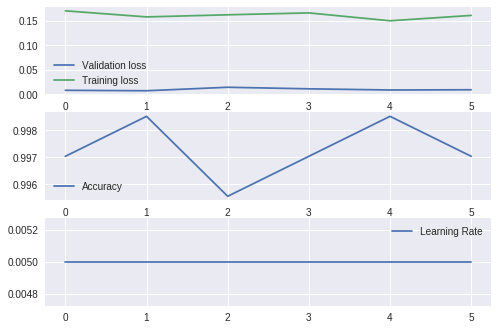

Epoch 7 , Batch 25/236 Loss:0.1778038591146469 Running time Epoch: 17.922 s, Running Time: 1002.936 s
Epoch 7 , Batch 50/236 Loss:0.009588432498276234 Running time Epoch: 33.598 s, Running Time: 1018.613 s
Epoch 7 , Batch 75/236 Loss:0.002964019775390625 Running time Epoch: 49.219 s, Running Time: 1034.233 s
Epoch 7 , Batch 100/236 Loss:0.11866863071918488 Running time Epoch: 64.971 s, Running Time: 1049.986 s
Epoch 7 , Batch 125/236 Loss:0.017849158495664597 Running time Epoch: 81.313 s, Running Time: 1066.327 s
Epoch 7 , Batch 150/236 Loss:0.09627731144428253 Running time Epoch: 96.944 s, Running Time: 1081.959 s
Epoch 7 , Batch 175/236 Loss:0.2470468282699585 Running time Epoch: 112.054 s, Running Time: 1097.068 s
Epoch 7 , Batch 200/236 Loss:0.004800872877240181 Running time Epoch: 127.597 s, Running Time: 1112.611 s
Epoch 7 , Batch 225/236 Loss:0.04468759521842003 Running time Epoch: 143.255 s, Running Time: 1128.269 s
======>Epoch 7 Finished , TLoss:0.15060076036234485 VLoss :0.0

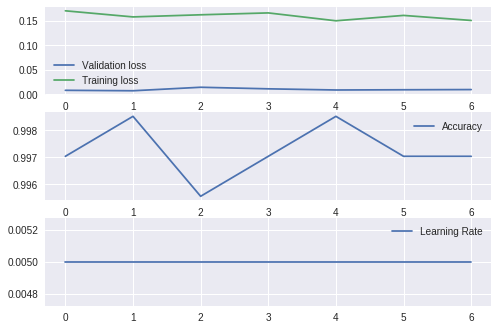

Epoch 8 , Batch 25/236 Loss:0.2513158321380615 Running time Epoch: 18.131 s, Running Time: 1166.953 s
Epoch 8 , Batch 50/236 Loss:0.0007949828868731856 Running time Epoch: 33.237 s, Running Time: 1182.059 s
Epoch 8 , Batch 75/236 Loss:0.11365287750959396 Running time Epoch: 49.194 s, Running Time: 1198.016 s
Epoch 8 , Batch 100/236 Loss:0.08044570684432983 Running time Epoch: 64.786 s, Running Time: 1213.608 s
Epoch 8 , Batch 125/236 Loss:0.1605054885149002 Running time Epoch: 80.956 s, Running Time: 1229.778 s
Epoch 8 , Batch 150/236 Loss:0.10921594500541687 Running time Epoch: 96.697 s, Running Time: 1245.520 s
Epoch 8 , Batch 175/236 Loss:0.5438719391822815 Running time Epoch: 112.389 s, Running Time: 1261.211 s
Epoch 8 , Batch 200/236 Loss:0.08222972601652145 Running time Epoch: 127.824 s, Running Time: 1276.646 s
Epoch 8 , Batch 225/236 Loss:0.02583564817905426 Running time Epoch: 144.085 s, Running Time: 1292.907 s
======>Epoch 8 Finished , TLoss:0.14980913524697703 VLoss :0.0103

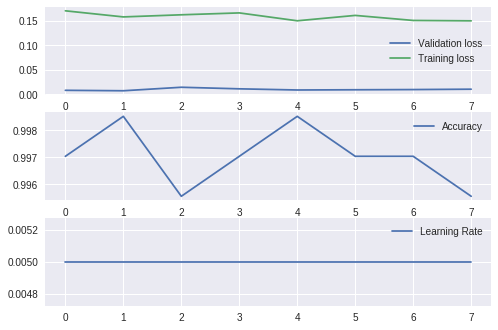

Epoch 9 , Batch 25/236 Loss:0.006445274222642183 Running time Epoch: 18.050 s, Running Time: 1331.324 s
Epoch 9 , Batch 50/236 Loss:0.4391458034515381 Running time Epoch: 33.505 s, Running Time: 1346.779 s
Epoch 9 , Batch 75/236 Loss:0.20185533165931702 Running time Epoch: 49.237 s, Running Time: 1362.511 s
Epoch 9 , Batch 100/236 Loss:0.0011004257248714566 Running time Epoch: 64.826 s, Running Time: 1378.100 s
Epoch 9 , Batch 125/236 Loss:0.03203151747584343 Running time Epoch: 81.480 s, Running Time: 1394.754 s
Epoch 9 , Batch 150/236 Loss:0.06526351720094681 Running time Epoch: 96.930 s, Running Time: 1410.204 s
Epoch 9 , Batch 175/236 Loss:0.391872763633728 Running time Epoch: 111.903 s, Running Time: 1425.177 s
Epoch 9 , Batch 200/236 Loss:0.1102299913764 Running time Epoch: 127.460 s, Running Time: 1440.734 s
Epoch 9 , Batch 225/236 Loss:0.008406219072639942 Running time Epoch: 144.023 s, Running Time: 1457.297 s
======>Epoch 9 Finished , TLoss:0.130573494382542 VLoss :0.01145888

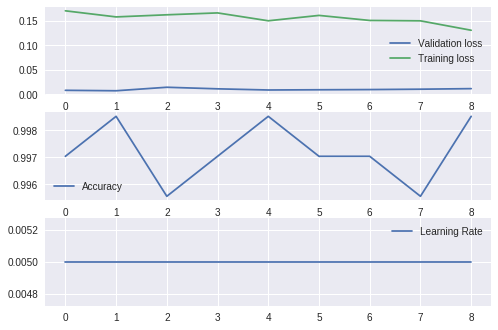

Epoch 10 , Batch 25/236 Loss:0.024580802768468857 Running time Epoch: 18.202 s, Running Time: 1495.964 s
Epoch 10 , Batch 50/236 Loss:0.0020649719517678022 Running time Epoch: 33.962 s, Running Time: 1511.724 s
Epoch 10 , Batch 75/236 Loss:0.2596251964569092 Running time Epoch: 48.967 s, Running Time: 1526.730 s
Epoch 10 , Batch 100/236 Loss:0.04408275708556175 Running time Epoch: 64.145 s, Running Time: 1541.907 s
Epoch 10 , Batch 125/236 Loss:0.2471362054347992 Running time Epoch: 80.547 s, Running Time: 1558.309 s
Epoch 10 , Batch 150/236 Loss:0.0128881074488163 Running time Epoch: 95.919 s, Running Time: 1573.681 s
Epoch 10 , Batch 175/236 Loss:0.2871991693973541 Running time Epoch: 111.867 s, Running Time: 1589.630 s
Epoch 10 , Batch 200/236 Loss:0.09766773134469986 Running time Epoch: 127.204 s, Running Time: 1604.966 s
Epoch 10 , Batch 225/236 Loss:0.07010085880756378 Running time Epoch: 143.014 s, Running Time: 1620.776 s
======>Epoch 10 Finished , TLoss:0.14079994304197266 VLo

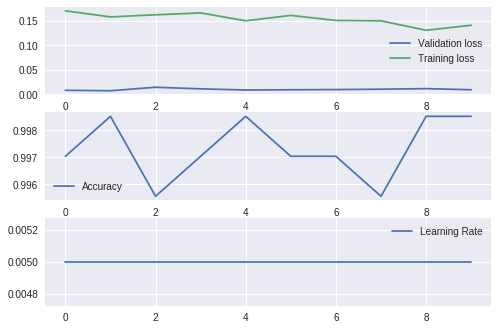

Epoch 11 , Batch 25/236 Loss:0.039057958871126175 Running time Epoch: 18.474 s, Running Time: 1659.635 s
Epoch 11 , Batch 50/236 Loss:0.14533798396587372 Running time Epoch: 34.137 s, Running Time: 1675.299 s
Epoch 11 , Batch 75/236 Loss:0.05313486233353615 Running time Epoch: 49.920 s, Running Time: 1691.081 s
Epoch 11 , Batch 100/236 Loss:0.3328811526298523 Running time Epoch: 64.737 s, Running Time: 1705.898 s
Epoch 11 , Batch 125/236 Loss:0.14559464156627655 Running time Epoch: 80.728 s, Running Time: 1721.889 s
Epoch 11 , Batch 150/236 Loss:0.2552769184112549 Running time Epoch: 96.430 s, Running Time: 1737.591 s
Epoch 11 , Batch 175/236 Loss:0.001962814247235656 Running time Epoch: 112.827 s, Running Time: 1753.988 s
Epoch 11 , Batch 200/236 Loss:0.008333053439855576 Running time Epoch: 128.572 s, Running Time: 1769.734 s
Epoch 11 , Batch 225/236 Loss:0.2867296040058136 Running time Epoch: 143.835 s, Running Time: 1784.996 s
======>Epoch 11 Finished , TLoss:0.14984481559027485 VL

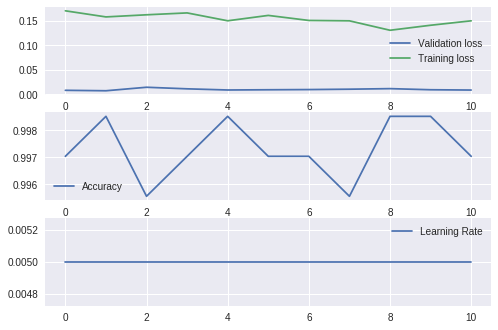

Epoch 12 , Batch 25/236 Loss:0.2668493688106537 Running time Epoch: 17.804 s, Running Time: 1823.941 s
Epoch 12 , Batch 50/236 Loss:0.0434381477534771 Running time Epoch: 33.694 s, Running Time: 1839.831 s
Epoch 12 , Batch 75/236 Loss:0.11739388108253479 Running time Epoch: 49.363 s, Running Time: 1855.500 s
Epoch 12 , Batch 100/236 Loss:0.022767754271626472 Running time Epoch: 64.606 s, Running Time: 1870.743 s
Epoch 12 , Batch 125/236 Loss:0.2943125367164612 Running time Epoch: 80.745 s, Running Time: 1886.882 s
Epoch 12 , Batch 150/236 Loss:0.21490564942359924 Running time Epoch: 96.314 s, Running Time: 1902.451 s
Epoch 12 , Batch 175/236 Loss:0.17110057175159454 Running time Epoch: 111.581 s, Running Time: 1917.717 s
Epoch 12 , Batch 200/236 Loss:0.12475141882896423 Running time Epoch: 127.027 s, Running Time: 1933.164 s
Epoch 12 , Batch 225/236 Loss:0.3531281352043152 Running time Epoch: 142.708 s, Running Time: 1948.845 s
======>Epoch 12 Finished , TLoss:0.1526963520278144 VLoss 

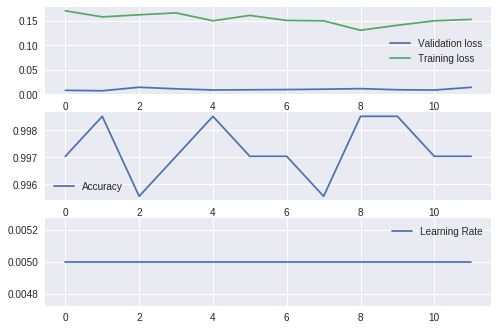

Epoch 13 , Batch 25/236 Loss:0.3295159935951233 Running time Epoch: 18.173 s, Running Time: 1987.208 s
Epoch 13 , Batch 50/236 Loss:0.07532772421836853 Running time Epoch: 33.566 s, Running Time: 2002.601 s


In [0]:
trainCEL(model,30,train_loader,valid_loader,learning_rate=0.005,opt="SGD",cont=True,modelPath="gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.987.pt")

# Testing

In [18]:

model=model.cuda()
model.eval()
chpt=load_model("gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.999.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 0.13821972249205575 Testing_accuracy : 0.9793938398361206


# Testing with google data

In [19]:
!wget -O google_test_data.zip "https://www.dropbox.com/s/3zmf1kq58o909rq/google_test_data.zip?dl=1"
!unzip google_test_data.zip -d data

--2019-01-02 18:25:03--  https://www.dropbox.com/s/3zmf1kq58o909rq/google_test_data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/3zmf1kq58o909rq/google_test_data.zip [following]
--2019-01-02 18:25:03--  https://www.dropbox.com/s/dl/3zmf1kq58o909rq/google_test_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00004df83e216035b08626a3cc.dl.dropboxusercontent.com/cd/0/get/AYrGuF21eJa7nHKSk4K-CaD-TTYfPL40WmO46mvEA_DyjnNSz5bkaVOfjpdJSpgGrcMTWJPjI2k81wNBocOvmw-sBiP9ulTsDpMoEHQ0Y4hNJ7Og_jNBF_jo5HVcmhpZr-UaxtBxTJ8UbWLX_-Q6CWRisS7uUlgzcBBub_nXSRpUm9q_5bR3U0rMWWnK0uTgxcQ/file?dl=1 [following]
--2019-01-02 18:25:04--  https://uc00004df83e216035b08626a3cc.dl.dropboxusercontent.com/cd/0/get/AYrGuF21eJa7nHKSk4K-Ca

In [0]:

!mkdir ./data
for i in range(102):
  name="{}".format(i+1)
  !mv $name "data"

mkdir: cannot create directory ‘./data’: File exists
mv: cannot stat '1': No such file or directory
mv: cannot stat '2': No such file or directory
mv: cannot stat '3': No such file or directory
mv: cannot stat '4': No such file or directory
mv: cannot stat '5': No such file or directory
mv: cannot stat '6': No such file or directory


RuntimeError: ignored

In [20]:

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 25
# Validation set size

test_dir="data"

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

print("Testing size : ",len(test_loader))


Testing size :  40


In [21]:

model=model.cuda()
model.eval()
chpt=load_model("gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.999.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 3.371274847537279 Testing_accuracy : 0.6102916598320007


In [22]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
train_on_gpu=True
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %2d %5s: %2d%% (%2d/%2d)' % (i+1,
            cat_to_name["{}".format(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (cat_to_name["{}".format(i+1)]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.367203

Test Accuracy of  1 pink primrose: 60% ( 6/10)
Test Accuracy of  2 hard-leaved pocket orchid: 60% ( 6/10)
Test Accuracy of  3 canterbury bells: 90% ( 9/10)
Test Accuracy of  4 sweet pea: 70% ( 7/10)
Test Accuracy of  5 english marigold: 90% ( 9/10)
Test Accuracy of  6 tiger lily: 40% ( 4/10)
Test Accuracy of  7 moon orchid: 77% ( 7/ 9)
Test Accuracy of  8 bird of paradise: 90% ( 9/10)
Test Accuracy of  9 monkshood: 90% ( 9/10)
Test Accuracy of 10 globe thistle: 50% ( 5/10)
Test Accuracy of 11 snapdragon: 40% ( 4/10)
Test Accuracy of 12 colt's foot: 70% ( 7/10)
Test Accuracy of 13 king protea: 90% ( 9/10)
Test Accuracy of 14 spear thistle: 40% ( 4/10)
Test Accuracy of 15 yellow iris: 70% ( 7/10)
Test Accuracy of 16 globe-flower: 80% ( 8/10)
Test Accuracy of 17 purple coneflower: 60% ( 6/10)
Test Accuracy of 18 peruvian lily: 80% ( 8/10)
Test Accuracy of 19 balloon flower: 70% ( 7/10)
Test Accuracy of 20 giant white arum lily: 80% ( 8/10)
Test Accuracy of 21 fire lil

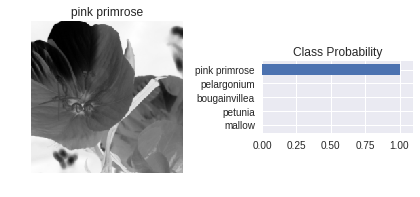

In [23]:
import numpy as np
def view_classify(img, ps,labels,k,title):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(k), ps)
    ax1.set_title(title)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(k))
    ax2.set_yticklabels(labels, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
dataiter = iter(test_loader)
images, labels = dataiter.next()
images,labels = images.cuda(),labels.cuda()
idx=2
img = images[idx].cpu()
lbl=labels[idx].cpu()

ps=torch.softmax(model(images),dim=1)
top_p,top_c= ps.topk(5,dim=1)

top_p,top_c=top_p[idx].cpu(),top_c[idx].cpu()

ll=[]
for a in top_c:
  ll.append(cat_to_name["{}".format(test_data.classes[a.item()])])
ll=ll[::-1]

inv_idx = torch.arange(top_p.size(0)-1, -1, -1).long()
top_p = top_p[inv_idx]

view_classify(img,top_p,ll,5,cat_to_name["{}".format(test_data.classes[lbl.item()])])

In [0]:
!cp -r data "/content/gdrive/My Drive/data_google"

# Testing with Original Test Data

In [25]:
!mkdir originalTest
!cd originalTes

/bin/bash: line 0: cd: originalTes: No such file or directory


In [26]:
!wget -O flower_data_orginal_test.zip "https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1"
!unzip flower_data_orginal_test.zip -d originalTest

--2019-01-02 18:29:57--  https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/da6ye9genbsdzbq/flower_data_original_test.zip [following]
--2019-01-02 18:29:58--  https://www.dropbox.com/s/dl/da6ye9genbsdzbq/flower_data_original_test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb85af3fc602683f0279d3cfa93.dl.dropboxusercontent.com/cd/0/get/AYq3oW8Sv1pZrbVoLThu1H3Wo-CyqI5vJnKQ1-v2h7FBomZnFkie8HuCYKF3H_dlw4hrml0zVkpv1EsLEp2OVh-XNP8C4gcJLm5P9s5Gcmx0O4IQAzfltlMTJmFd9-GVew_QfDrZuIuAhga6ZDI7kt_tN-5Qiw5H4BRna2T9JaB4sF8_JPagKXwFPamixZ4KzQk/file?dl=1 [following]
--2019-01-02 18:29:58--  https://ucb85af3fc602683f0279d3cfa93.dl.dropboxusercontent.com/cd/0

In [27]:
!mkdir ./originalTest
for i in range(102):
  name="{}".format(i+1)
  !mv $name "originalTest"

mkdir: cannot create directory ‘./originalTest’: File exists
mv: cannot stat '1': No such file or directory
mv: cannot stat '2': No such file or directory


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-59504380904e>", line 4, in <module>
    get_ipython().system('mv $name "originalTest"')
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_shell.py", line 67, in system
    output = _system_commands._system_compat(self, *args, **kwargs)  # pylint:disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_system_commands.py", line 438, in _system_compat
    shell.var_expand(cmd, depth=2), clear_streamed_output=False)
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_system_commands.py", line 181, in _run_command
    delay_millis=500) as update_stdin_widget:
  File "/usr/lib/python3.6/contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_system_commands.p

KeyboardInterrupt: ignored

In [28]:

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 25
# Validation set size

#valid_dir="/content/gdrive/My Drive/test"
test_dir="originalTest"

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

print("Testing size : ",len(test_loader))


Testing size :  33


In [29]:

model=model.cuda()
model.eval()
chpt=load_model("gdrive/My Drive/Colab Notebooks/udacity/net14_suite_0.01LR-SCHPLAT_sgd_densenet161_brightness_unfrozen_0.999.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 0.12197565150068206 Testing_accuracy : 0.9762678146362305
